# CLASIFICACIÓN DE SUPERVIVIENTES DEL TITANIC

## 1. Carga de librerías necesarias

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score, recall_score, precision_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 2. Carga de los datasets

In [40]:
data = pd.read_csv("train.csv", header=0, sep=',', decimal='.', na_values='')
data_t = pd.read_csv("test.csv", header=0, sep=',', decimal='.', na_values='')

display(data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 3. Exploración de datos

### Análisis iniciales de los datos

In [25]:
# Dimensiones del dataset de entrenamiento
print("- Dimensiones del dataset de entrenamiento (Filas, Columnas):")
print(data.shape, "\n")

# Número de valores nulos en cada variable
n_nan = data.isna().sum()
print("- Número de valores nulos en cada variable:")
print(n_nan, "\n")

# Tipos de datos
print("- Tipos de datos:")
numericas = data.select_dtypes(include=['int64', 'float64'])
categoricas = data.select_dtypes(include=['object'])
print("Columnas numéricas:", numericas.columns.tolist())
print("Columnas categóricas:", categoricas.columns.tolist())

# Análisis de frecuencia de supervivientes
porcentajes = data['Survived'].value_counts()
print("\n- Distribución de supervivencia:")
print(porcentajes)

- Dimensiones del dataset de entrenamiento (Filas, Columnas):
(891, 12) 

- Número de valores nulos en cada variable:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

- Tipos de datos:
Columnas numéricas: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Columnas categóricas: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

- Distribución de supervivencia:
Survived
0    549
1    342
Name: count, dtype: int64


### Gráficos de distribución de la supervivencia y relación entre variables

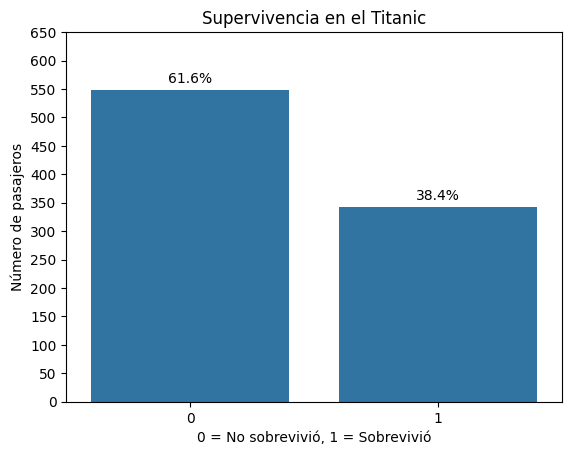

Survived    0    1
Sex               
female     81  233
male      468  109


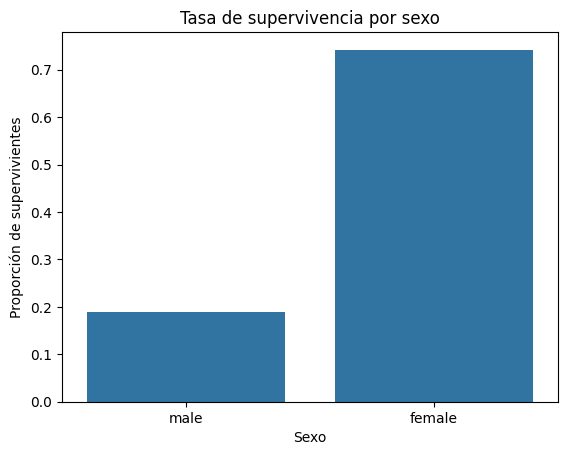

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


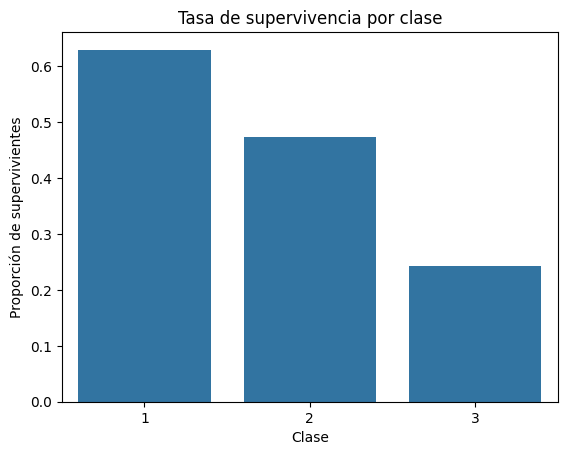

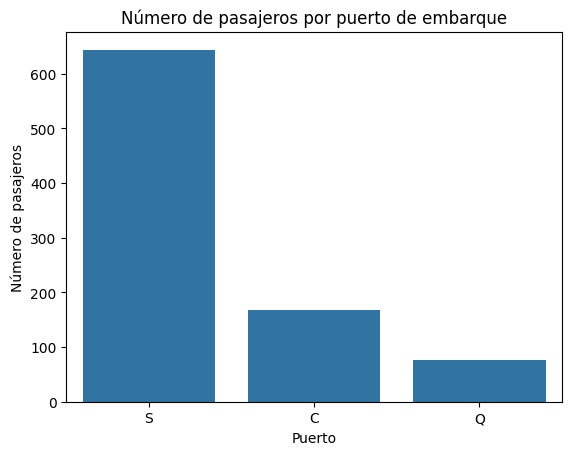

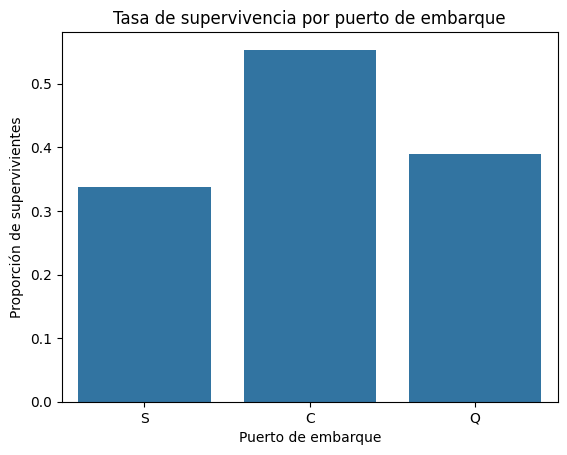

In [26]:
# Gráfico con la distribución de superviviencia
ax = sns.countplot(x="Survived", data=data)
plt.yticks(range(0, 700, 50))
total = len(data)
## Añadir porcentajes arriba de cada barra
for p in ax.patches:
    porcentaje = 100 * p.get_height() / total
    ax.annotate(f'{porcentaje:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')
plt.title("Supervivencia en el Titanic")
plt.xlabel("0 = No sobrevivió, 1 = Sobrevivió")
plt.ylabel("Número de pasajeros")
plt.show()

# Tabla de supervivencia por sexo
tabla_sexo = pd.crosstab(data['Sex'], data['Survived'])
print(tabla_sexo)

# Relación entre supervivencia y sexo
ax = sns.barplot(x="Sex", y="Survived", data=data, errorbar=None)
plt.title("Tasa de supervivencia por sexo")
plt.ylabel("Proporción de supervivientes")
plt.xlabel("Sexo")
plt.show()

# Tabla de supervivencia por clase
tabla_clase = pd.crosstab(data['Pclass'], data['Survived'])
print(tabla_clase)

# Relación entre supervivencia y clase
ax = sns.barplot(x="Pclass", y="Survived", data=data, errorbar=None)
plt.title("Tasa de supervivencia por clase")
plt.ylabel("Proporción de supervivientes")
plt.xlabel("Clase")
plt.show()

# Conteo de pasajeros por puerto
sns.countplot(x="Embarked", data=data)
plt.title("Número de pasajeros por puerto de embarque")
plt.xlabel("Puerto")
plt.ylabel("Número de pasajeros")
plt.show()

# Relación entre supervivencia y puerto de embarque
ax = sns.barplot(x="Embarked", y="Survived", data=data, errorbar=None)
plt.title("Tasa de supervivencia por puerto de embarque")
plt.ylabel("Proporción de supervivientes")
plt.xlabel("Puerto de embarque")
plt.show()

### Gráficos observando la edad y las tarifas

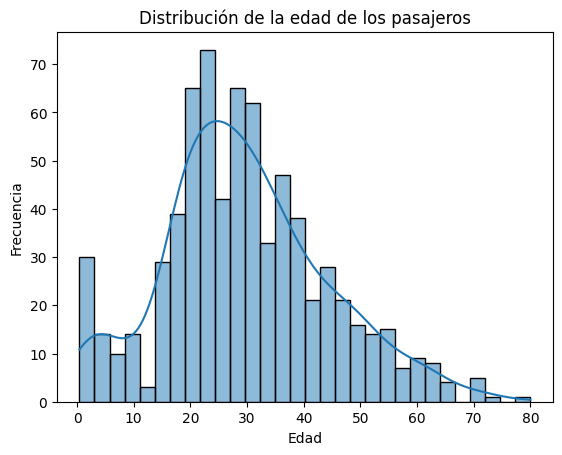

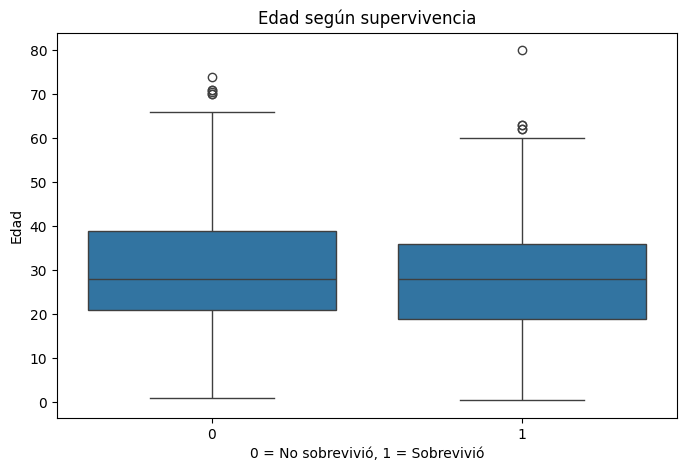

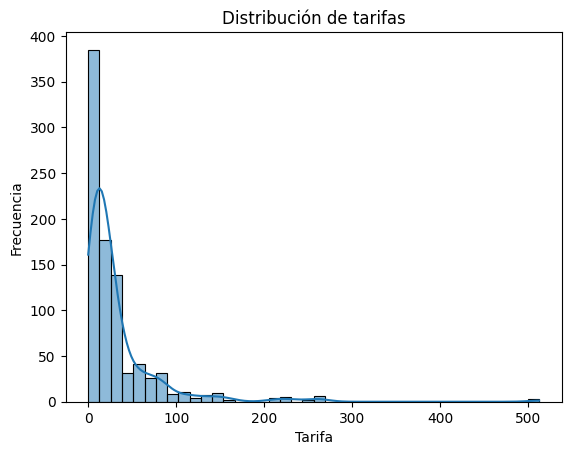

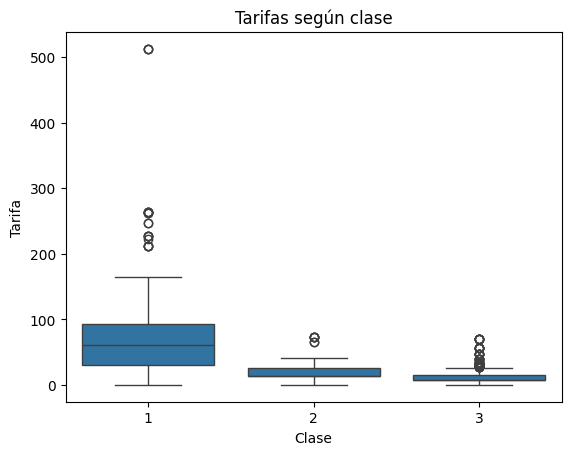

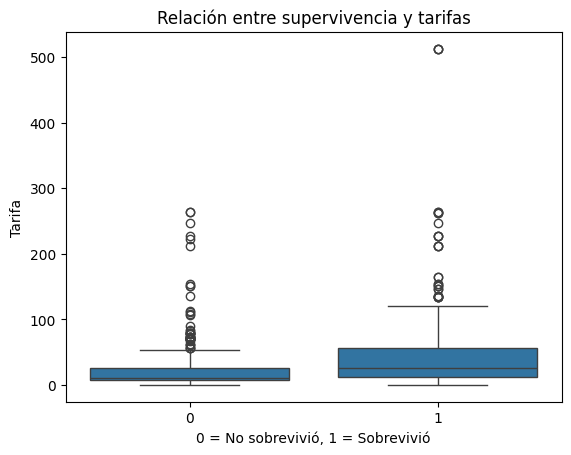

In [27]:
# Distribución de personas por edad (obviando valores desconocidos)
sns.histplot(data['Age'], bins=30, kde=True)
plt.title("Distribución de la edad de los pasajeros")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

# Relación entre supervivencia y edad del pasajero
plt.figure(figsize=(8,5))
sns.boxplot(x="Survived", y="Age", data=data)
plt.title("Edad según supervivencia")
plt.xlabel("0 = No sobrevivió, 1 = Sobrevivió")
plt.ylabel("Edad")
plt.show()

# Distribución de las tarifas
sns.histplot(data['Fare'], bins=40, kde=True)
plt.title("Distribución de tarifas")
plt.xlabel("Tarifa")
plt.ylabel("Frecuencia")
plt.show()

# Relación entre clase y tarifas
sns.boxplot(x="Pclass", y="Fare", data=data)
plt.title("Tarifas según clase")
plt.xlabel("Clase")
plt.ylabel("Tarifa")
plt.show()

# Relación entre supervivencia y tarifas
sns.boxplot(x="Survived", y="Fare", data=data)
plt.title("Relación entre supervivencia y tarifas")
plt.xlabel("0 = No sobrevivió, 1 = Sobrevivió")
plt.ylabel("Tarifa")
plt.show()

### Gráficos avanzados con relaciones

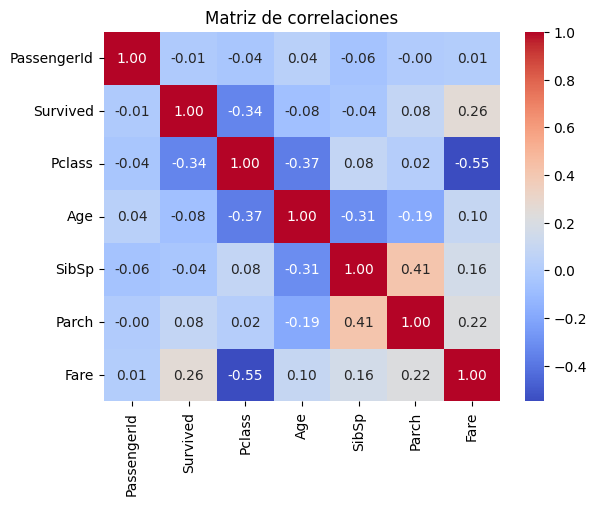

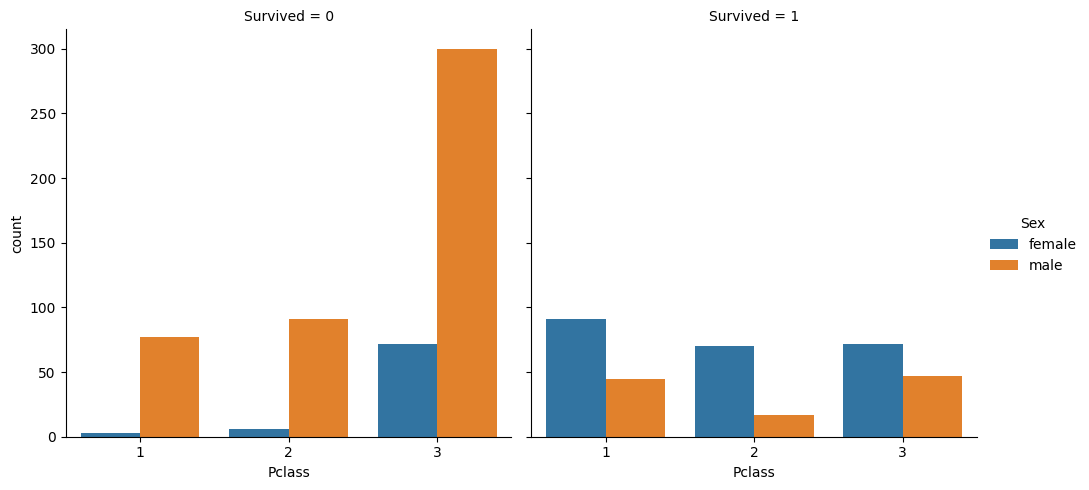

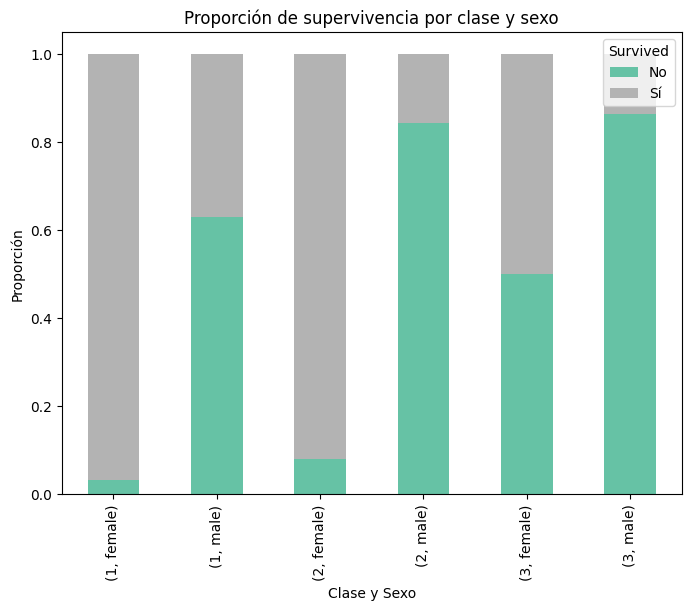

In [28]:
# Matriz de correlaciones: Sirve para ver qué variables numéricas están relacionadas.
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

# Relación entre supervivencia, clase y sexo
sns.catplot(
    data=data, x="Pclass", hue="Sex", col="Survived",
    kind="count", height=5, aspect=1
)

# Proporción de supervivientes por clase y sexo.
cross = pd.crosstab([data['Pclass'], data['Sex']], data['Survived'], normalize='index')
cross.plot(kind="bar", stacked=True, figsize=(8,6), colormap="Set2")
plt.title("Proporción de supervivencia por clase y sexo")
plt.ylabel("Proporción")
plt.xlabel("Clase y Sexo")
plt.legend(title="Survived", labels=["No", "Sí"])
plt.show()



## 4. Preprocesamiento

### Imputación de valores nulos

In [29]:
# Age -> imputación con la mediana
data['Age'] = data['Age'].fillna(data['Age'].median())

# Cabin -> muchos valores nulos, se elimina la variable
data = data.drop(columns=['Cabin'])

# Embarked -> imputación con la moda (puerto más frecuente)
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Número de valores nulos en cada variable
n_nan = data.isna().sum()
print("- Número de valores nulos en cada variable:")
print(n_nan, "\n")


- Número de valores nulos en cada variable:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64 



### Nueva variable FamilySize

In [30]:
# Nueva variable Tamaño de familia (FamilySize)
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

display(data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1


### Codificación de variables categóricas

In [31]:
# Codificación de la variable 'Sex' -> hombre 0 -- mujer 1
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Codificación one-hot para la variable 'Embarked'
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

### Reorganización del dataset

In [32]:
# Eliminación de variables innecesarias
data = data.drop(columns=['PassengerId', 'Name', 'Ticket'])

# Reorganizamos dataset con la variable objetivo (clase) 'Survived' al final
colum_clase = 0
columnas = data.columns[:colum_clase].to_list() + data.columns[(colum_clase+1):].to_list() + data.columns[colum_clase:(colum_clase+1)].to_list()
data = data[columnas]

display(data)

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_Q,Embarked_S,Survived
0,3,0,22.0,1,0,7.2500,2,False,True,0
1,1,1,38.0,1,0,71.2833,2,False,False,1
2,3,1,26.0,0,0,7.9250,1,False,True,1
3,1,1,35.0,1,0,53.1000,2,False,True,1
4,3,0,35.0,0,0,8.0500,1,False,True,0
...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,1,False,True,0
887,1,1,19.0,0,0,30.0000,1,False,True,1
888,3,1,28.0,1,2,23.4500,4,False,True,0
889,1,0,26.0,0,0,30.0000,1,False,False,1


### Normalización del dataset y preparación para los modelos

In [33]:
# Copia del dataset preparado
data_norm = data.copy()

# Columnas numéricas que hay que normalizar
cols = ['Age', 'Fare', 'FamilySize']

# Escalamos variables con StandardScaler
scaler = StandardScaler()
data_norm[cols] = scaler.fit_transform(data_norm[cols])

# Teniendo dos dataset, uno base y otro normalizado, preparamos datos para los modelos
X = data.drop(columns=['Survived'])
X_norm = data_norm.drop(columns=['Survived'])
y = data['Survived']


## 5. Modelos de aprendizaje

### Folds y scorer necesarios

In [13]:
# Se crea un generador de folds estratificados partiendo el conjunto en 5 trozos
folds5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# Se crea un generador de folds estratificados partiendo el conjunto en 10 trozos
folds10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Creamos un 'scorer' para las métricas que queremos obtener
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0)
}

### Modelo baseline: Dummy Classifier

In [100]:
# Creamos el Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent", random_state=1234)

# Obtenemos resultados con validación cruzada
scores = cross_validate(dummy, X, y, cv=folds10, scoring=scoring, verbose=0)

print("\nResultado Dummy Classifier:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))


Resultado Dummy Classifier:
Accuracy (mean ± std): 0.6162 ± 0.0037


### Regresión logística

#### - Optimización sobre accuracy

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Resultados:
Accuracy (mean ± std): 0.7969 ± 0.0371
F1-score (mean ± std): 0.7213 ± 0.0622
Recall (mean ± std): 0.6934 ± 0.0899
Precision (mean ± std): 0.7562 ± 0.0413

Mejores hiperparámetros: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state'

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


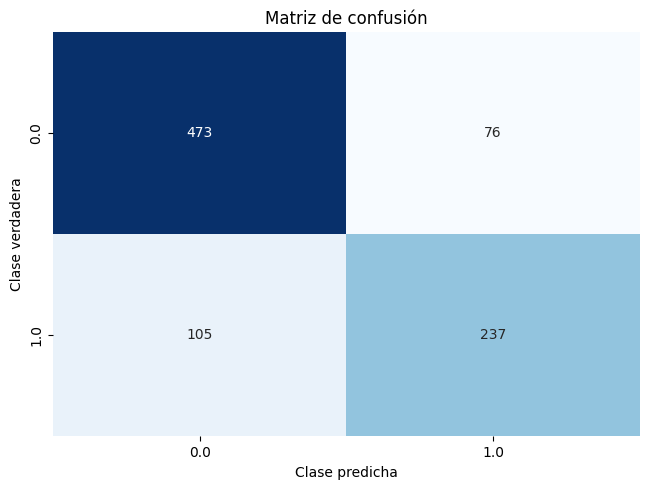

In [101]:
# Creamos la Regresión Logística
log_reg = LogisticRegression(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(log_reg, param_grid, cv=folds5, scoring='accuracy', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X_norm, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_accuracy'])  # Índice del mejor modelo según accuracy
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X_norm, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

#### - Optimización sobre F1-Score

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Resultados:
Accuracy (mean ± std): 0.7936 ± 0.0391
F1-score (mean ± std): 0.7181 ± 0.0638
Recall (mean ± std): 0.6934 ± 0.0899
Precision (mean ± std): 0.7487 ± 0.0430

Mejores hiperparámetros: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state'

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


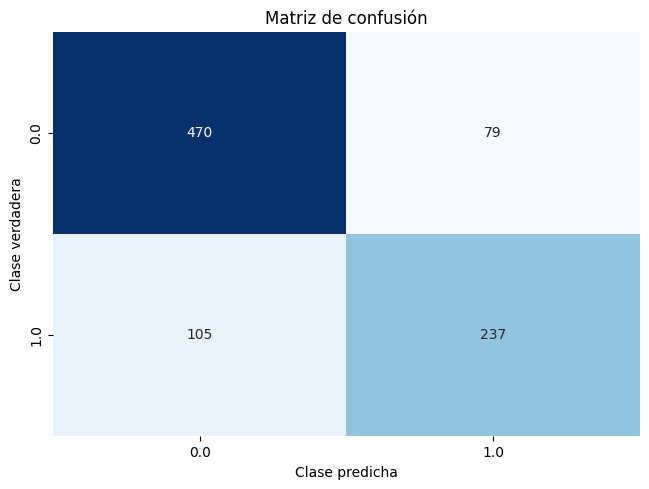

In [111]:
# Creamos la Regresión Logística
log_reg = LogisticRegression(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(log_reg, param_grid, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X_norm, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según f1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X_norm, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

### Regresión Logística (balanceada)

#### - Optimización sobre accuracy

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished



Resultados:
Accuracy (mean ± std): 0.7823 ± 0.0403
F1-score (mean ± std): 0.7299 ± 0.0534
Recall (mean ± std): 0.7696 ± 0.0757
Precision (mean ± std): 0.6968 ± 0.0490

Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1234, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candida

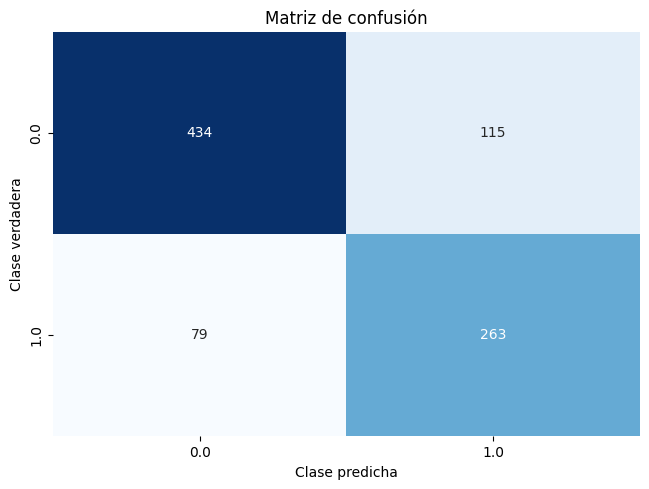

In [102]:
# Creamos la Regresión Logística
log_reg = LogisticRegression(random_state=1234, class_weight='balanced')

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(log_reg, param_grid, cv=folds5, scoring='accuracy', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X_norm, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_accuracy'])  # Índice del mejor modelo según accuracy
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X_norm, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

#### - Optimización sobre F1-Score

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished



Resultados:
Accuracy (mean ± std): 0.7868 ± 0.0405
F1-score (mean ± std): 0.7349 ± 0.0556
Recall (mean ± std): 0.7755 ± 0.0838
Precision (mean ± std): 0.7012 ± 0.0446

Mejores hiperparámetros: {'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1234, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 cand

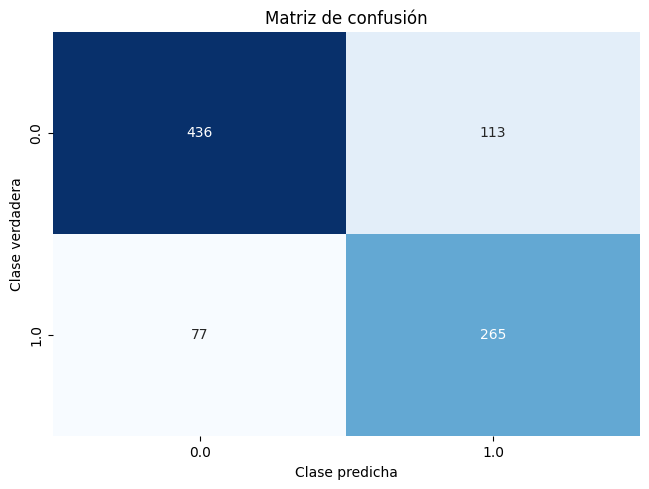

In [113]:
# Creamos la Regresión Logística
log_reg = LogisticRegression(random_state=1234, class_weight='balanced')

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(log_reg, param_grid, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X_norm, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según F1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X_norm, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

### Árbol de decisión

#### - Optimización sobre accuracy

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished



Resultados:
Accuracy (mean ± std): 0.8126 ± 0.0334
F1-score (mean ± std): 0.7324 ± 0.0571
Recall (mean ± std): 0.6761 ± 0.0844
Precision (mean ± std): 0.8064 ± 0.0440

Mejores hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 1234, 'splitter': 'best'} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5

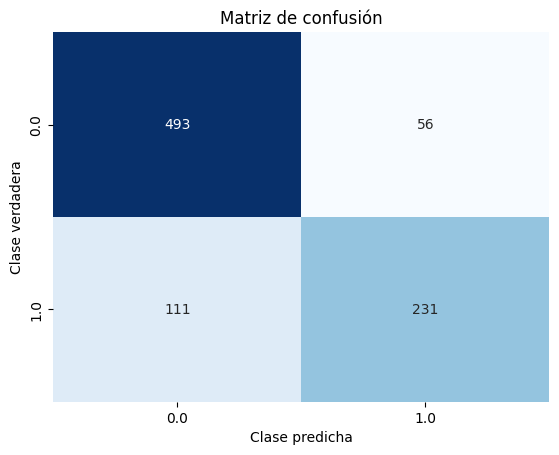

In [103]:
# Creamos el Árbol de decisión
arbol_dec = DecisionTreeClassifier(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(arbol_dec, param_grid, cv=folds5, scoring='accuracy', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_accuracy'])  # Índice del mejor modelo según accuracy
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

#### - Optimización sobre F1-Score

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished



Resultados:
Accuracy (mean ± std): 0.8048 ± 0.0360
F1-score (mean ± std): 0.7192 ± 0.0634
Recall (mean ± std): 0.6613 ± 0.0934
Precision (mean ± std): 0.7969 ± 0.0457

Mejores hiperparámetros: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 1234, 'splitter': 'best'} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5

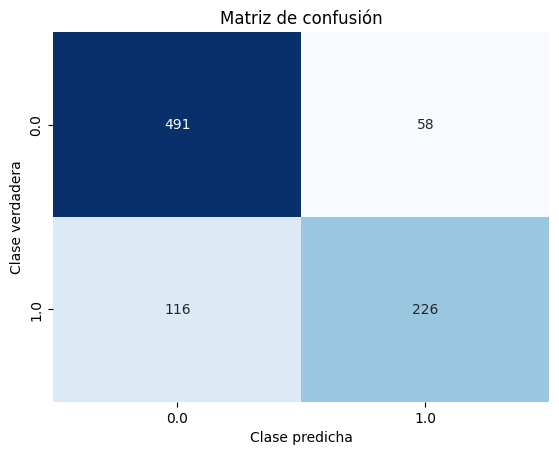

In [114]:
# Creamos el Árbol de decisión
arbol_dec = DecisionTreeClassifier(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(arbol_dec, param_grid, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según F1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

### Random Forest

#### - Optimización sobre accuracy

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 25.9min finished



Resultados:
Accuracy (mean ± std): 0.8171 ± 0.0429
F1-score (mean ± std): 0.7450 ± 0.0667
Recall (mean ± std): 0.7052 ± 0.0947
Precision (mean ± std): 0.7952 ± 0.0509

Mejores hiperparámetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False} 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitt

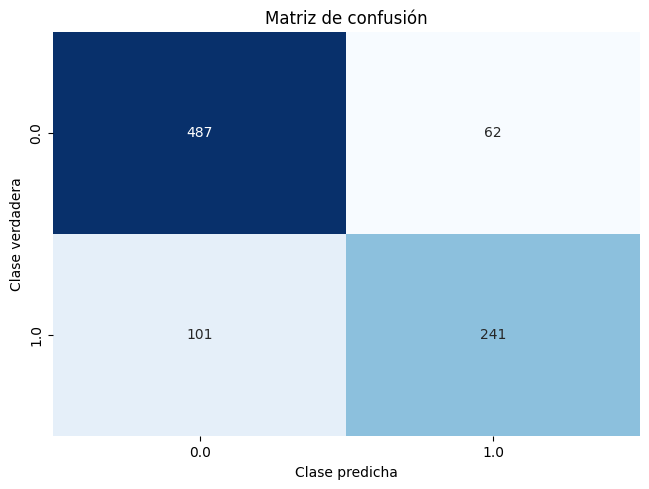

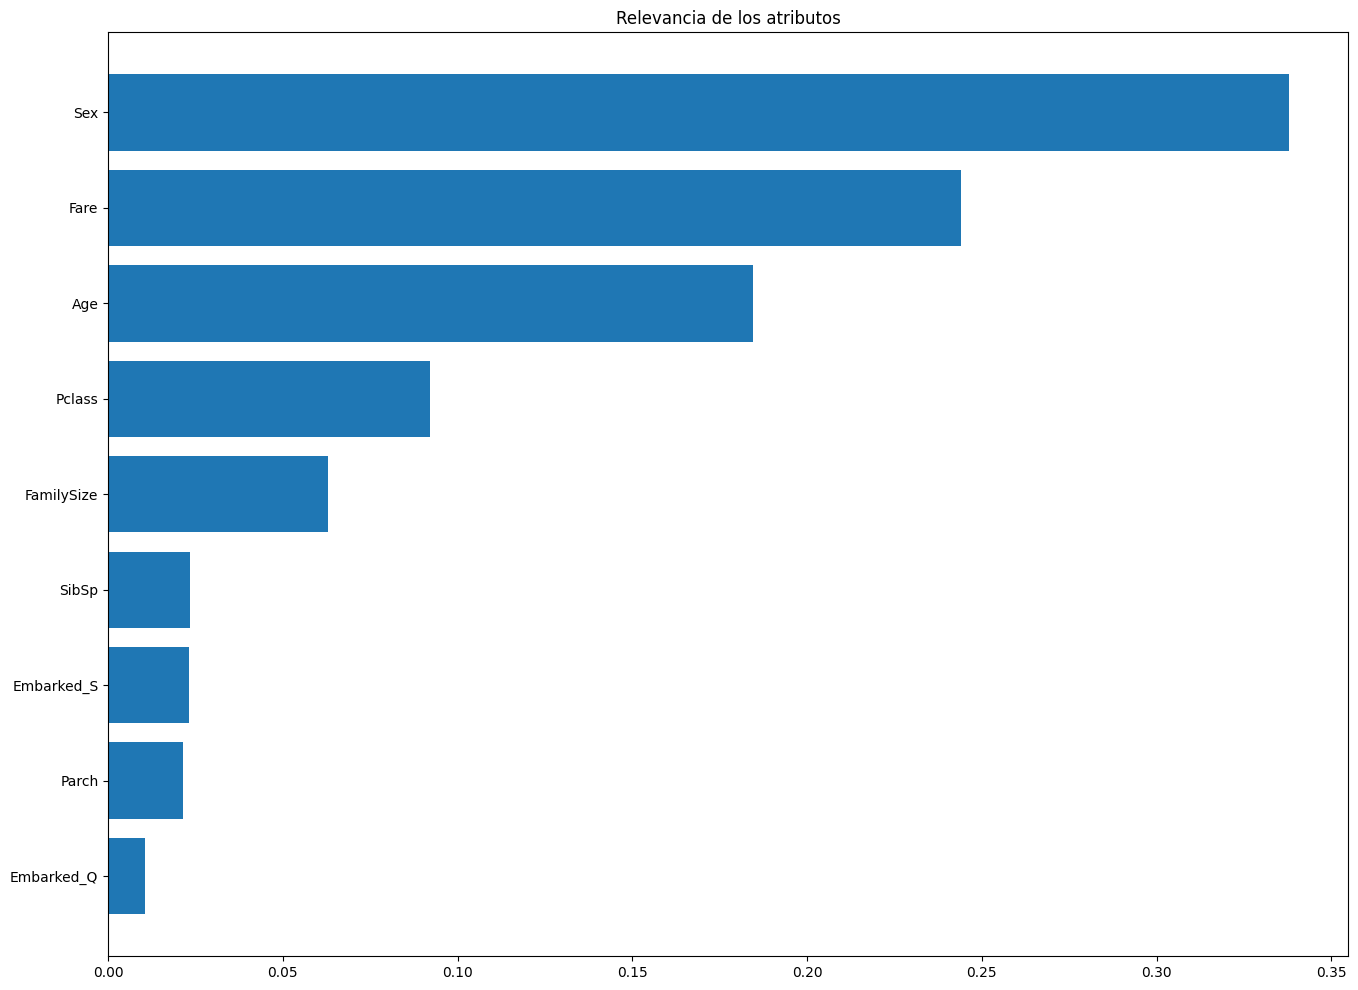

In [104]:
# Creamos el Random Forest
rf = RandomForestClassifier(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 500],   # nº de árboles
    'max_depth': [None, 5, 10, 20],    # profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],   # nº mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],     # nº mínimo de muestras por hoja
    'max_features': ['sqrt', 'log2']   # nº de variables consideradas por split
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(rf, param_grid, cv=folds5, scoring='accuracy', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_accuracy'])  # Índice del mejor modelo según accuracy
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

# Obtenemos la importancia de los atributos
importances = best_model.feature_importances_
(num_ejemplos, num_atributos) = X.shape
indices = np.argsort(importances)[::-1]
fig, ax = plt.subplots()
fig.set_size_inches((16,12))
ax.set_title("Relevancia de los atributos")
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]])
plt.show()

#### - Optmización sobre F1-Score

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.5min finished



Resultados:
Accuracy (mean ± std): 0.8249 ± 0.0434
F1-score (mean ± std): 0.7566 ± 0.0648
Recall (mean ± std): 0.7167 ± 0.0907
Precision (mean ± std): 0.8057 ± 0.0526

Mejores hiperparámetros: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False} 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitt

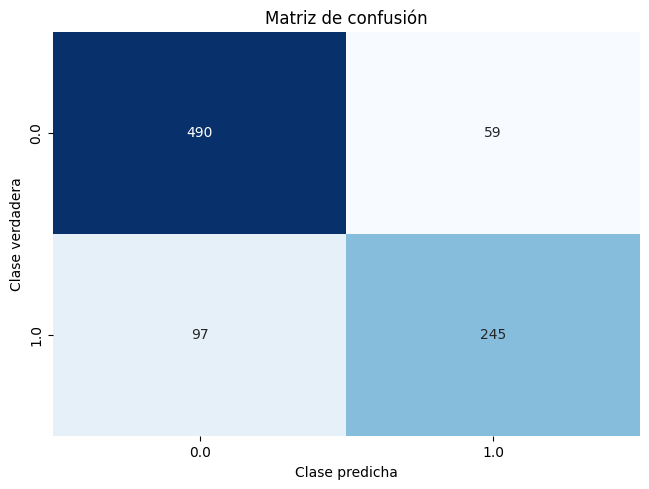

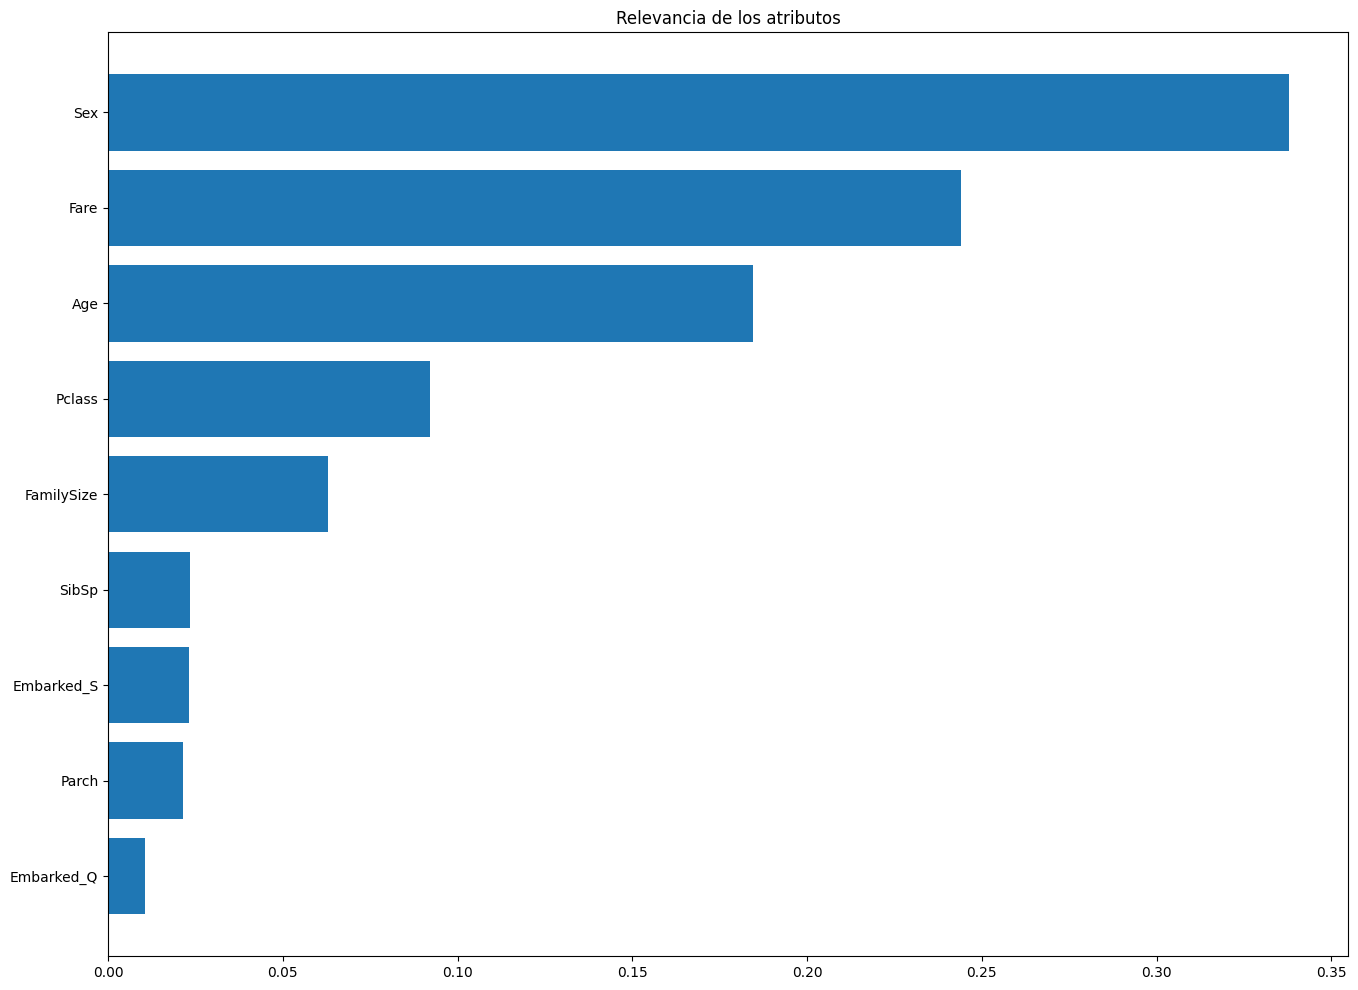

In [115]:
# Creamos el Random Forest
rf = RandomForestClassifier(random_state=1234)

# Grid para la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 500],   # nº de árboles
    'max_depth': [None, 5, 10, 20],    # profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],   # nº mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],     # nº mínimo de muestras por hoja
    'max_features': ['sqrt', 'log2']   # nº de variables consideradas por split
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(rf, param_grid, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según F1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

# Obtenemos la importancia de los atributos
importances = best_model.feature_importances_
(num_ejemplos, num_atributos) = X.shape
indices = np.argsort(importances)[::-1]
fig, ax = plt.subplots()
fig.set_size_inches((16,12))
ax.set_title("Relevancia de los atributos")
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]])
plt.show()

### XGBoost (Extreme Gradient Boosting)

#### - Optimizacion sobre accuracy

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished



Resultados:
Accuracy (mean ± std): 0.8205 ± 0.0436
F1-score (mean ± std): 0.7393 ± 0.0767
Recall (mean ± std): 0.6792 ± 0.1146
Precision (mean ± std): 0.8250 ± 0.0526

Mejores hiperparámetros: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 1234, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': N

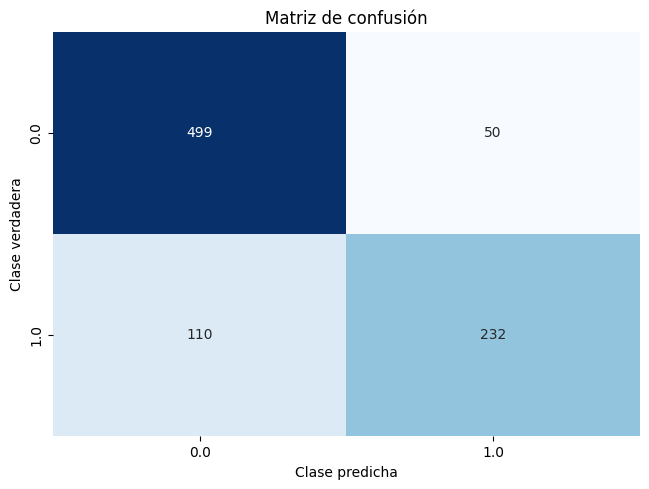

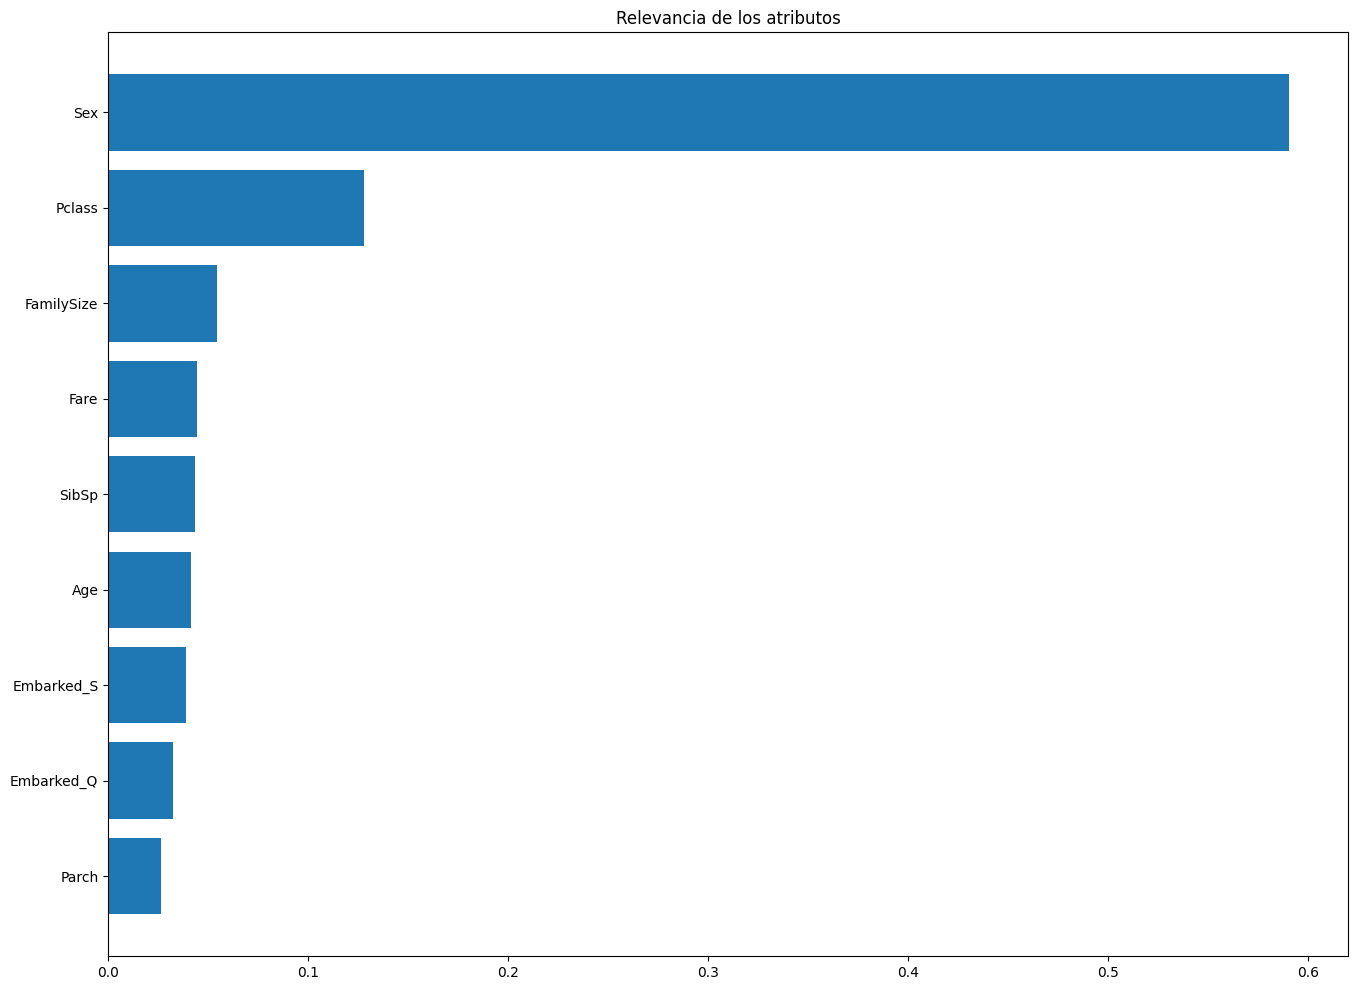

In [110]:
# Definimos el modelo base
xgb = XGBClassifier(random_state=1234, eval_metric="logloss")

# Grid de hiperparámetros básicos
param_grid = {
    'n_estimators': [100, 200, 500],   # nº de árboles
    'max_depth': [3, 5, 7],            # profundidad de árboles
    'learning_rate': [0.01, 0.1, 0.2], # tasa de aprendizaje
    'subsample': [0.8, 1.0],           # muestreo de filas
    'colsample_bytree': [0.8, 1.0]     # muestreo de columnas
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(xgb, param_grid, cv=folds5, scoring='accuracy', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_accuracy'])  # Índice del mejor modelo según accuracy
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

# Obtenemos la importancia de los atributos
importances = best_model.feature_importances_
(num_ejemplos, num_atributos) = X.shape
indices = np.argsort(importances)[::-1]
fig, ax = plt.subplots()
fig.set_size_inches((16,12))
ax.set_title("Relevancia de los atributos")
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]])
plt.show()

#### - Optimización sobre F1-Score

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.0min finished



Resultados:
Accuracy (mean ± std): 0.8328 ± 0.0390
F1-score (mean ± std): 0.7652 ± 0.0586
Recall (mean ± std): 0.7166 ± 0.0852
Precision (mean ± std): 0.8270 ± 0.0558

Mejores hiperparámetros: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 1234, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': N

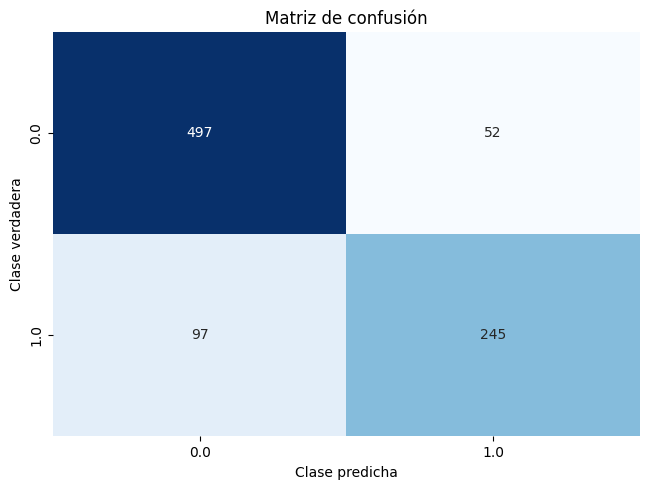

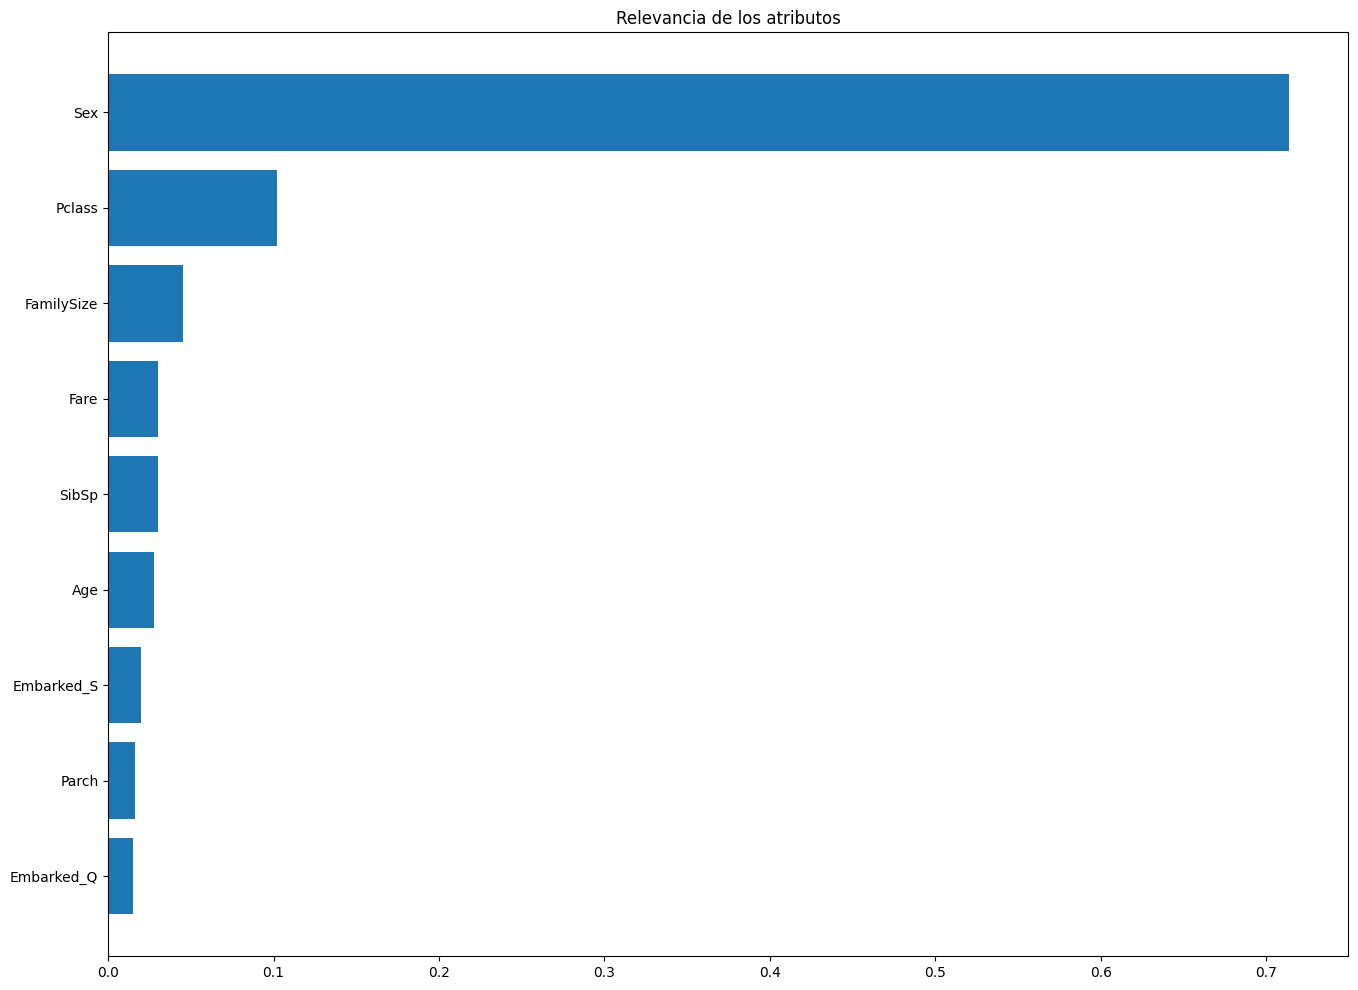

In [35]:
# Definimos el modelo base
xgb = XGBClassifier(random_state=1234, eval_metric="logloss")

# Grid de hiperparámetros básicos
param_grid = {
    'n_estimators': [100, 200, 500],   # nº de árboles
    'max_depth': [3, 5, 7],            # profundidad de árboles
    'learning_rate': [0.01, 0.1, 0.2], # tasa de aprendizaje
    'subsample': [0.8, 1.0],           # muestreo de filas
    'colsample_bytree': [0.8, 1.0]     # muestreo de columnas
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(xgb, param_grid, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según F1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

# Obtenemos las predicciones durante la validación cruzada
y_pred = cross_val_predict(grid_search, X, y, cv=folds10, verbose=0)

# Obtenemos la matriz de confusión
cm = metrics.confusion_matrix(y, y_pred, labels=[0.0, 1.0])
df_cm = pd.DataFrame(cm, index=[0.0, 1.0], columns=[0.0, 1.0])
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión")
plt.tight_layout()
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

# Obtenemos la importancia de los atributos
importances = best_model.feature_importances_
(num_ejemplos, num_atributos) = X.shape
indices = np.argsort(importances)[::-1]
fig, ax = plt.subplots()
fig.set_size_inches((16,12))
ax.set_title("Relevancia de los atributos")
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]])
plt.show()

## 6. Puesta a punto del modelo seleccionado: XGBoost con optimización en F1-Score

### Ajuste de hiperparámetros para mayor rendimiento

In [34]:
# Definimos el modelo base
xgb = XGBClassifier(random_state=1234, eval_metric="logloss")

# Mini-grid refinado alrededor de los mejores valores encontrados
param_grid_refined = {
    'n_estimators': [500, 800, 1000],               # probamos más árboles
    'max_depth': [6, 7, 8],                         # alrededor de 7
    'learning_rate': [0.001, 0.003, 0.005, 0.01],   # más bajo que 0.01
    'subsample': [0.9, 1.0],                        # pequeño ajuste alrededor de 1.0
    'colsample_bytree': [0.8, 0.9, 1.0]             # probamos un poco más
}

# GridSearchCV con validación cruzada de 5 folds (Optimización --->  scoring='accuracy' / 'f1')
grid_search = GridSearchCV(xgb, param_grid_refined, cv=folds5, scoring='f1', verbose=1, n_jobs=-1)

# Obtenemos resultados con validación cruzada
scores = cross_validate(grid_search, X, y, cv=folds10, scoring=scoring, return_estimator=True, verbose=1)

print("\nResultados:")
print("Accuracy (mean ± std): %0.4f ± %0.4f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("F1-score (mean ± std): %0.4f ± %0.4f" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Recall (mean ± std): %0.4f ± %0.4f" % (scores['test_recall'].mean(), scores['test_recall'].std()))
print("Precision (mean ± std): %0.4f ± %0.4f" % (scores['test_precision'].mean(), scores['test_precision'].std()))

# Obtenemos el mejor modelo
best_index = np.argmax(scores['test_f1'])  # Índice del mejor modelo según F1
best_model = scores['estimator'][best_index].best_estimator_  # Acceder al mejor modelo
print("\nMejores hiperparámetros:", best_model.get_params(),"\n")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed:   21.3s remaining:   21.3s


KeyboardInterrupt: 

### Definición del mejor modelo

In [ ]:
# Valores de los hiperparámetros que proporcionaron mejores resultados
best_params = {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.01,
    'subsample': 1.0,
    'colsample_bytree': 0.8
}

# Definición de el modelo base
xgb_final = XGBClassifier(random_state=1234, eval_metric="logloss", **best_params)

# Entrenamiento con todo el dataset de entrenamiento
xgb_final.fit(X, y)

# Evaluación en train
y_train_pred = xgb_final.predict(X)

print("Resultados en TRAIN:")
print(classification_report(y, y_train_pred))

Resultados en TRAIN:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       549
           1       0.93      0.84      0.88       342

    accuracy                           0.91       891
   macro avg       0.92      0.90      0.91       891
weighted avg       0.91      0.91      0.91       891



## 7. Predicciones

### Preprocesado del dataset de test

In [41]:
# Age -> imputación con la mediana
data_t['Age'] = data_t['Age'].fillna(data_t['Age'].median())

# Cabin -> muchos valores nulos, se elimina la variable
data_t = data_t.drop(columns=['Cabin'])

# Embarked -> imputación con la moda (puerto más frecuente)
data_t['Embarked'] = data_t['Embarked'].fillna(data_t['Embarked'].mode()[0])

# Número de valores nulos en cada variable
n_nan = data_t.isna().sum()
print("- Número de valores nulos en cada variable:")
print(n_nan, "\n")

# Nueva variable Tamaño de familia (FamilySize)
data_t['FamilySize'] = data_t['SibSp'] + data_t['Parch'] + 1

display(data_t)

# Codificación de la variable 'Sex' -> hombre 0 -- mujer 1
data_t['Sex'] = data_t['Sex'].map({'male': 0, 'female': 1})

# Codificación one-hot para la variable 'Embarked'
data_t = pd.get_dummies(data_t, columns=['Embarked'], drop_first=True)

# Guardado de la variable PassengerId para resultados
passenger_id = data_t["PassengerId"]

# Eliminación de variables innecesarias
data_t = data_t.drop(columns=['PassengerId', 'Name', 'Ticket'])

display(data_t)

# Preparamos datos para el modelo
X_test = data_t

- Número de valores nulos en cada variable:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64 



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,3
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,27.0,0,0,A.5. 3236,8.0500,S,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,1
416,1308,3,"Ware, Mr. Frederick",male,27.0,0,0,359309,8.0500,S,1


,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,1,True,False
1,3,1,47.0,1,0,7.0000,2,False,True
2,2,0,62.0,0,0,9.6875,1,True,False
3,3,0,27.0,0,0,8.6625,1,False,True
4,3,1,22.0,1,1,12.2875,3,False,True
...,...,...,...,...,...,...,...,...,...
413,3,0,27.0,0,0,8.0500,1,False,True
414,1,1,39.0,0,0,108.9000,1,False,False
415,3,0,38.5,0,0,7.2500,1,False,True
416,3,0,27.0,0,0,8.0500,1,False,True


### Predicciones sobre test.csv

In [42]:
y_test_pred = xgb_final.predict(X_test)

results = pd.DataFrame({
    "PassengerId": passenger_id,
    "Survived": y_test_pred
})

results.to_csv("submission.csv", index=False)
